In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [5]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

# 🔥 LeWagon Kaggle Batch Challenge

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

Welcome to your first Kaggle competition!

Your objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Load

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y`!
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [6]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [93]:
data.Id

0          1
1          2
2          3
3          4
4          5
        ... 
1455    1456
1456    1457
1457    1458
1458    1459
1459    1460
Name: Id, Length: 1460, dtype: int64

In [7]:
X = data.drop(columns = ['Id','SalePrice'])
y = data['SalePrice']

<AxesSubplot:>

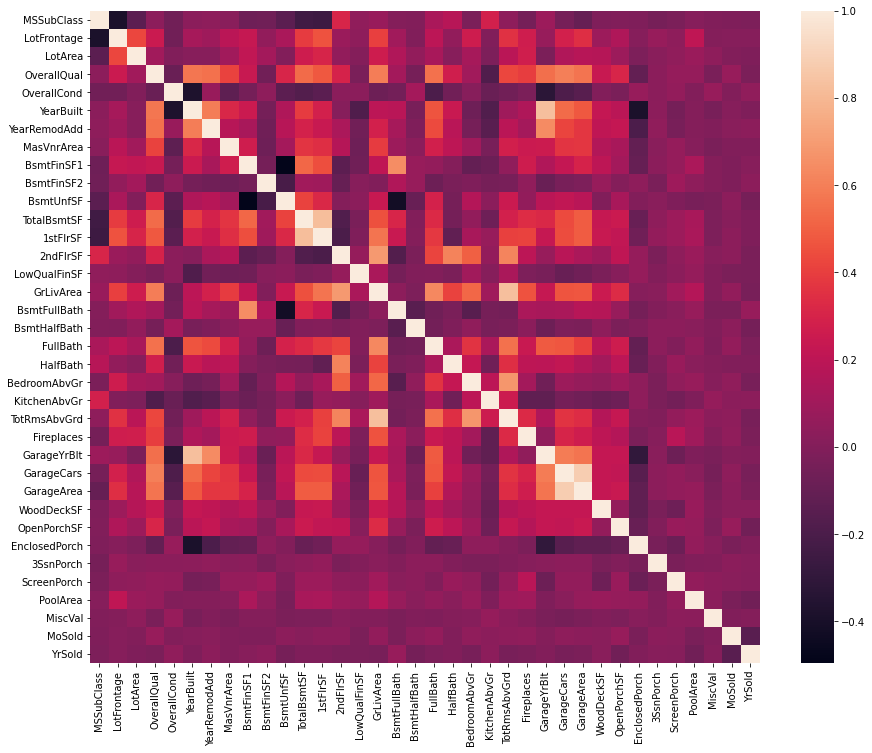

In [13]:
plt.figure(figsize=(15,12))
sns.heatmap(X.corr(), cmap='rocket')

# 🐣 BASELINE

## Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [11]:
X.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [60]:
feat_categorical_nunique = X[make_column_selector(dtype_include=['O'])].nunique()

In [72]:
feat_categorical_nunique.sum()

252

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with 50-100 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

There are 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

<AxesSubplot:ylabel='Count'>

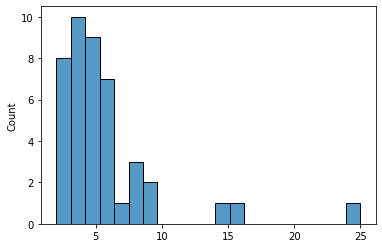

In [63]:
sns.histplot(feat_categorical_nunique)

💡 As a starter, what about simply removing all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration.

❓ Store features to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [74]:
feat_categorical_nunique[feat_categorical_nunique < 7]

MSZoning         5
Street           2
Alley            2
LotShape         4
LandContour      4
Utilities        2
LotConfig        5
LandSlope        3
BldgType         5
RoofStyle        6
MasVnrType       4
ExterQual        4
ExterCond        5
Foundation       6
BsmtQual         4
BsmtCond         4
BsmtExposure     4
BsmtFinType1     6
BsmtFinType2     6
Heating          6
HeatingQC        5
CentralAir       2
Electrical       5
KitchenQual      4
FireplaceQu      5
GarageType       6
GarageFinish     3
GarageQual       5
GarageCond       5
PavedDrive       3
PoolQC           3
Fence            4
MiscFeature      4
SaleCondition    6
dtype: int64

In [75]:
# categorical features to one-hot-encode
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 7]

🧪 Test your code below (and clear the cell once it passed)

In [76]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- /home/rodrigovg/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/rodrigovg/code/RodrigoVGoulart/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-1.20.0, anyio-3.1.0
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


## Preprocessing pipeline - V1 minimal baseline

---
❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [365]:
# Dummy code your pipeline first

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enconder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['int64', 'float64'])),
    ('cat_transformer', cat_transformer, feat_categorical_small.index)],
    remainder='drop') 


In [111]:
pd.DataFrame(preprocessor.fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


❓ Look at the **shape** of your preprocessed dataframe.

In [113]:
shape_preproc_baseline = pd.DataFrame(preprocessor.fit_transform(X)).shape

🧪 Test your code below

In [114]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- /home/rodrigovg/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/rodrigovg/code/RodrigoVGoulart/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-1.20.0, anyio-3.1.0
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


## Model baseline

❓ Pipe a basic Ridge regressor to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [104]:
pipe_baseline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Ridge())
])

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- Create a scorer using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and store it into a variable named `rmsle`
- Create also the negative score `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` requires a score to _maximize_

In [232]:
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [233]:
rmsle = make_scorer(RMSLE)

In [234]:
rmsle_neg = make_scorer(RMSLE, greater_is_better=False)

❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    
Store your mean score as `score_baseline`

In [235]:
cross_validate(pipe_baseline, X, y, scoring=rmsle, cv = 5)

{'fit_time': array([0.13674831, 0.11806703, 0.14063954, 0.18452215, 0.20170856]),
 'score_time': array([0.04089689, 0.05659795, 0.04177547, 0.12063313, 0.10572028]),
 'test_score': array([0.16544312, 0.16837325, 0.1723072 , 0.16444757, 0.16157424])}

In [236]:
score_baseline = cross_validate(pipe_baseline, X, y, scoring=rmsle, cv = 5)['test_score'].mean()
score_baseline

0.16642907520861638

## Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [155]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

In [156]:
pipe_baseline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c4c7a0550>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enconder',
                                                                   OneHotEncoder...
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])),
                ('model', Ridge())])

In [190]:
y_pred_baseline = pipe_baseline.predict(X_test.drop(columns='Id'))

In [194]:
store = pd.DataFrame({'Id': X_test['Id'], 'SalePrice' : y_pred_baseline})

In [195]:
store

,Id,SalePrice
0,1461,113256.769594
1,1462,136811.014544
2,1463,174901.688343
3,1464,190322.363348
4,1465,187149.759609
...,...,...
1454,2915,66081.031488
1455,2916,65988.765038
1456,2917,157216.077182
1457,2918,111472.495917


❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [419]:
store.to_csv('data/submission_baseline.csv', columns=['Id', 'SalePrice'], index=False)

In [420]:
pd.read_csv('data/submission_baseline.csv')

,Id,SalePrice
0,1461,113256.769594
1,1462,136811.014544
2,1463,174901.688343
3,1464,190322.363348
4,1465,187149.759609
...,...,...
1454,2915,66081.031488
1455,2916,65988.765038
1456,2917,157216.077182
1457,2918,111472.495917


🧪 Test your code

In [229]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- /home/rodrigovg/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/rodrigovg/code/RodrigoVGoulart/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-1.20.0, anyio-3.1.0
collecting ... collected 4 items

tests/test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.26s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline ste

# 🏋️‍♀️ ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below
- **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Models**

- Linear Models: fine-tune regularization ?
- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- ...

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

## Preprocessing Iteration (⚠️ come back here after your first Ensemble model)

⏩ Collapse me if you don't use me!

### Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how ths works

In [281]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 2.,  2.],
       [ 0., -1.]])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice (**do a quick iteration first**)
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [324]:
one_hot_features = feat_categorical_small[feat_categorical_small < 6]
one_hot_features

MSZoning        5
Street          2
Alley           2
LotShape        4
LandContour     4
Utilities       2
LotConfig       5
LandSlope       3
BldgType        5
MasVnrType      4
ExterQual       4
ExterCond       5
BsmtQual        4
BsmtCond        4
BsmtExposure    4
HeatingQC       5
CentralAir      2
Electrical      5
KitchenQual     4
FireplaceQu     5
GarageFinish    3
GarageQual      5
GarageCond      5
PavedDrive      3
PoolQC          3
Fence           4
MiscFeature     4
dtype: int64

NameError: name 'X' is not defined

In [314]:
ordinal_features = feat_categorical_small[feat_categorical_small == 6]
ordinal_features

RoofStyle        6
Foundation       6
BsmtFinType1     6
BsmtFinType2     6
Heating          6
GarageType       6
SaleCondition    6
dtype: int64

In [317]:
X[ordinal_features.index]['RoofStyle'].unique()

array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object)

In [319]:
to_encode = [X[i].unique() for i in X[ordinal_features.index]]

In [320]:
to_encode

[array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object),
 array(['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], dtype=object),
 array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object),
 array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object),
 array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object),
 array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
       dtype=object),
 array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
       dtype=object)]

In [321]:
ordinal_encoder = OrdinalEncoder(
    categories = to_encode,
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

In [371]:
preproc_ordinal2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enconder', ordinal_encoder)
])

preproc_nominal2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enconder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

preprocessor_encoded = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_exclude=["object"])),
    ('preproc_ordinal', preproc_ordinal, ordinal_features.index),
    ('preproc_nominal', preproc_nominal, one_hot_features.index)],
    remainder='drop')

preprocessor_encoded

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c20ad6490>),
                                ('preproc_ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('enconder',
                                                  OrdinalEncoder(categories=[array(['Gable', 'Hip...
                                 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'MasVnrType', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object'))])

In [372]:
pd.DataFrame(preprocessor_encoded.fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out historgram of your target `y`. Normally distributed variables should be easier to predict with linear models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

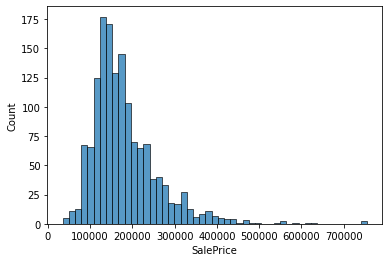

In [345]:
sns.histplot(y)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

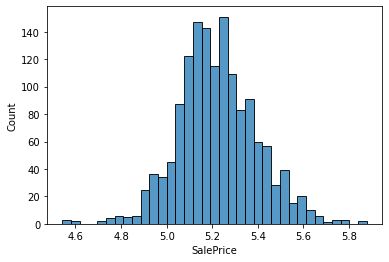

In [348]:
y_log = np.log10(y)
sns.histplot(y_log)

### Statistical Feature Selection (1h)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  
Choose one of the 3 options below

#### (option 1 - recommended) univariate feature selection based on relationship with target `y`

❓ We will use sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) tools directly in your pipeline.
- Add a `SelectPercentile` filter (coupled with `mutual_info_regression` for the statistical test to use) at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!  

In [386]:
preproc_ordinal2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enconder', ordinal_encoder),
#     ('select_percentile', SelectPercentile()),
])

preproc_nominal2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enconder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
#     ('select_percentile', SelectPercentile()),
])



preprocessor_encoded_feat2 = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_exclude=["object"])),
    ('preproc_ordinal', preproc_ordinal2, ordinal_features.index),
    ('preproc_nominal', preproc_nominal2, one_hot_features.index)],
    remainder='drop')

In [387]:
pd.DataFrame(preprocessor_encoded_feat2.fit_transform(X,y))

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### (option 2) multivariate feature selection based their common relationship with target `y`

❓ We will use sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) tools directly in your pipeline.
- Add a `SequentialFeatureSelector` at the end of your `preproc` pipeline.
- This will recursively filter-out least important features according to `feature_permutation` importance!  
- Probably overkill for such small dataset!

#### (option 3) Filter based only on the properties of `X` ?

❓ Use Pearson's correlation combined with a heatmap...
- to check visually whether some **numerical** features almost entirely explain others. 
- Then, create a "filter" in your pipeline that removes any correlated below a certain threshold

In [362]:
pd.DataFrame(data[make_column_selector(dtype_exclude=["object"])].corr() == 1)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MSSubClass,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LotFrontage,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LotArea,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
OverallQual,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
OverallCond,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
YearBuilt,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
YearRemodAdd,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
MasVnrArea,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
BsmtFinSF1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


❓ Use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) combined with a heatmap...
- to whether some **ordinally encoded** features are almost entirely "ordered" similarily than others
- Then, create a "filter" in your pipeline that removes any ordinal features correlated below a certain threshold

❓ Another way to filter out feature relies solely on removing those with the lowest variance.  
- Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Try to add a `VarianceThreshold` to the end of your pipeline

### Final preproc pipeline
❓ store here your final version of the preproc pipeline

## Models Iteration

In [ ]:
pipe_tree = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Ridge())
])

In [250]:
forest = RandomForestRegressor(n_estimators = 100)

pipe_tree = Pipeline([
    ('preprocessing', preprocessor),
    ('model', forest)
])

score_forest = cross_validate(pipe_tree, X, y, scoring=rmsle, cv = 5)

In [251]:
score_forest['test_score'].mean()

0.14776187484426875

In [274]:
kneighbors = KNeighborsRegressor()

bagged_kn = BaggingRegressor(kneighbors, n_estimators = 10)

pipe_bag_kn = Pipeline([
    ('preprocessing', preprocessor),
    ('model', bagged_kn)
])

score_bag_kn = cross_validate(pipe_bag_kn, X, y, scoring=rmsle, cv = 5)

In [276]:
score_bag_kn['test_score'].mean()

0.21492880814031107

In [277]:
xgb_reg = XGBRegressor()

pipe_xgb = Pipeline([
    ('preprocessing', preprocessor),
    ('model', xgb_reg)
])

score_xgb = cross_validate(pipe_xgb, X, y, scoring=rmsle, cv = 5)

In [278]:
score_xgb['test_score'].mean()

0.1399195644658548

In [259]:
ensemble = StackingRegressor(
    estimators = [("rf", RandomForestRegressor()),
                  ("knn", KNeighborsRegressor(n_neighbors=10))],
    final_estimator = LinearRegression())

pipe_ense = Pipeline([
    ('preprocessing', preprocessor),
    ('ensemble', ensemble)
])

score_ense = cross_validate(pipe_ense, X, y, scoring=rmsle, cv = 5)

In [261]:
score_ense['test_score'].mean()

0.1423005827635458

In [267]:
ensemble2 = StackingRegressor(
    estimators = [("xgb", XGBRegressor())],
    final_estimator = LinearRegression())

pipe_ense2 = Pipeline([
    ('preprocessing', preprocessor),
    ('ensemble', ensemble2)
])

score_ense2 = cross_validate(pipe_ense2, X, y, scoring=rmsle, cv = 5)

In [268]:
score_ense2['test_score'].mean()

0.1398213127820328

In [272]:
ensemble3 = StackingRegressor(
    estimators = [("xgb", XGBRegressor())],
    final_estimator = KNeighborsRegressor())

pipe_ense3 = Pipeline([
    ('preprocessing', preprocessor),
    ('ensemble', ensemble3)
])

score_ense3 = cross_validate(pipe_ense3, X, y, scoring=rmsle, cv = 5)

In [273]:
score_ense3['test_score'].mean()

0.15340984797315899

# 🏅FINAL SUBMISSION (start at 4h30 max)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [403]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

In [ ]:
preprocessor_encoded_feat2

In [388]:
ensemble_final = StackingRegressor(
    estimators = [("xgb", XGBRegressor())],
    final_estimator = LinearRegression())

pipe_ense_final = Pipeline([
    ('preprocessing', preprocessor_encoded_feat2),
    ('ensemble', ensemble_final)
])

score_final = cross_validate(pipe_ense_final, X, y, scoring=rmsle, cv = 5)

In [389]:
score_final['test_score'].mean()

0.1431849849765755

In [398]:
ensemble_final = StackingRegressor(
    estimators = [("xgb", XGBRegressor())],
    final_estimator = LinearRegression())

pipe_ense_final = Pipeline([
    ('preprocessing', preprocessor_encoded_feat2),
    ('ensemble', ensemble_final)
])

score_final_2 = cross_validate(pipe_ense_final, X, y_log, scoring='neg_root_mean_squared_error', cv = 5)

In [400]:
-score_final_2['test_score'].mean()

0.062468952157594536

In [401]:
xgb_reg_final = XGBRegressor()

pipe_xgb_final = Pipeline([
    ('preprocessing', preprocessor),
    ('model', xgb_reg_final)
])

score_xgb = cross_validate(pipe_xgb_final, X, y_log, scoring='neg_root_mean_squared_error', cv = 5)

In [402]:
-score_xgb['test_score'].mean()

0.06351701821954665

In [477]:
ensemble_final = StackingRegressor(
    estimators = [("xgb", XGBRegressor())],
    final_estimator = LinearRegression())

pipe_last = Pipeline([
    ('preprocessing', preprocessor_encoded_feat2),
    ('statistical_select', SelectPercentile(mutual_info_regression, percentile=75)),
    ('ensemble', ensemble_final)
])

In [443]:
score_last = cross_validate(pipe_last, X, y_log, scoring='neg_root_mean_squared_error', cv = 5)

In [478]:
score_last2 = cross_validate(pipe_last, X, y, scoring=rmsle, cv = 5)

In [480]:
score_last2['test_score'].mean()

0.14558935582361365

In [447]:
-score_last['test_score'].mean()

0.07039309799177809

In [449]:
pipe_last.fit(X, y_log)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c20949be0>),
                                                 ('preproc_ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enconder',
                                                                   OrdinalEncode...
                                                             learning_rate=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None,
                                                             reg_alpha=None,
                                                             reg_lambda=None,
                                                             scale_pos_weight=None,
                                                             subsample=None,
                                                             tree_method=None,
                                                             validate_parameters=None,
                                                             verbosity=None))],
                                   final_estimator=LinearRegression()))])

In [458]:
10 ** pipe_last.predict(X_test.drop(columns=['Id']))

array([127784.79, 139971.92, 179234.38, ..., 150704.88, 118417.73,
       223820.94], dtype=float32)

In [460]:
result_last = pd.DataFrame({'Id': X_test['Id'], 'SalePrice' : 10 ** pipe_last.predict(X_test.drop(columns=['Id']))})

In [461]:
result_last

,Id,SalePrice
0,1461,127784.789062
1,1462,139971.921875
2,1463,179234.375000
3,1464,190368.421875
4,1465,203957.109375
...,...,...
1454,2915,78241.796875
1455,2916,79585.875000
1456,2917,150704.875000
1457,2918,118417.726562


In [462]:
result_last.to_csv('data/predictions2.csv', columns=['Id', 'SalePrice'], index=False)

In [463]:
pd.read_csv('data/predictions2.csv')

,Id,SalePrice
0,1461,127784.790
1,1462,139971.920
2,1463,179234.380
3,1464,190368.420
4,1465,203957.110
...,...,...
1454,2915,78241.800
1455,2916,79585.875
1456,2917,150704.880
1457,2918,118417.730


In [405]:
X_test.drop(columns=['Id'])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [431]:
pipe_xgb_final.fit(X, y_log)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c20c8fd60>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enconder',
                                                                   OneHotEncoder...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [432]:
result_log = pipe_xgb_final.predict(X_test.drop(columns=['Id']))
result_log

array([5.0825605, 5.202991 , 5.2828197, ..., 5.2375717, 5.0829124,
       5.34611  ], dtype=float32)

In [433]:
result = 10 ** result_log
result

array([120937.375, 159584.61 , 191787.25 , ..., 172811.12 , 121035.41 ,
       221875.77 ], dtype=float32)

In [434]:
result = pd.DataFrame({'Id': X_test['Id'], 'SalePrice' : result})

In [435]:
result

,Id,SalePrice
0,1461,120937.375000
1,1462,159584.609375
2,1463,191787.250000
3,1464,194052.843750
4,1465,188717.281250
...,...,...
1454,2915,83336.085938
1455,2916,78603.007812
1456,2917,172811.125000
1457,2918,121035.406250


In [436]:
result.to_csv('data/predictions.csv', columns=['Id', 'SalePrice'], index=False)

In [437]:
pd.read_csv('data/predictions.csv')

,Id,SalePrice
0,1461,120937.375
1,1462,159584.610
2,1463,191787.250
3,1464,194052.840
4,1465,188717.280
...,...,...
1454,2915,83336.086
1455,2916,78603.010
1456,2917,172811.120
1457,2918,121035.410
